In [45]:
import pandas as pd 
import numpy as np
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt

from prophet import Prophet

import datetime
from datetime import datetime

In [2]:
data_consumo = pd.read_csv('DatosConsumoCombustibles.csv')
data_importaciones = pd.read_csv('DatosImportacionCombustibles.csv')

In [3]:
data_consumo.head()

Unnamed: 0  Anio  Mes  GasolinaSuper  GasolinaRegular  TotalGasolinas  \
0           3  2000    1      308156.82        202645.20       510802.02   
1           4  2000    2      307766.31        205530.96       513297.27   
2           5  2000    3      331910.29        229499.56       561409.85   
3           6  2000    4      315648.08        210680.40       526328.48   
4           7  2000    5      319667.97        208164.34       527832.31   

      Diesel  DieselLS  DieselULS  TotalDiesel  ...  AceitesLubricantes  \
0  634667.06       NaN        NaN    634667.06  ...                 NaN   
1  642380.66       NaN        NaN    642380.66  ...                 NaN   
2  699807.25       NaN        NaN    699807.25  ...                 NaN   
3  586803.98       NaN        NaN    586803.98  ...                 NaN   
4  656948.20       NaN        NaN    656948.20  ...                 NaN   

   GrasasLubricantes  Solventes  Naftas  Ceras  CrudoNacional  Butano  \
0                NaN        NaN     NaN    NaN            NaN     NaN   
1                NaN        NaN     NaN    NaN            NaN     NaN   
2                NaN        NaN     NaN    NaN            NaN     NaN   
3                NaN        NaN     NaN    NaN            NaN     NaN   
4                NaN        NaN     NaN    NaN            NaN     NaN   

   Orimulsion  MezclasOleosas       Total  
0         NaN             NaN  1750544.64  
1         NaN             NaN  1773220.22  
2         NaN             NaN  1909498.79  
3         NaN             NaN  1800932.86  
4         NaN             NaN  1941771.90  

[5 rows x 27 columns]

In [4]:
data_importaciones.head()

Unnamed: 0  Anio  Mes  GasolinaSuper  GasolinaRegular  TotalGasolinas  \
0           3  2001    1      373963.96        177776.50       551740.46   
1           4  2001    2      243091.07        123115.99       366207.06   
2           5  2001    3      312084.38        161726.42       473810.80   
3           6  2001    4      285054.89        127338.74       412393.63   
4           7  2001    5      300913.67        168730.19       469643.86   

      Diesel  DieselLS  DieselULS  TotalDiesel  ...  Solventes  Naftas  Ceras  \
0  566101.99       NaN        NaN    566101.99  ...        NaN     NaN    NaN   
1  489525.80       NaN        NaN    489525.80  ...        NaN     NaN    NaN   
2  575559.68       NaN        NaN    575559.68  ...        NaN     NaN    NaN   
3  437745.42       NaN        NaN    437745.42  ...        NaN     NaN    NaN   
4  552609.13       NaN        NaN    552609.13  ...        NaN     NaN    NaN   

   Butano  PetroleoReconstit     MTBE  Orimulsion  MezclasOleosas  \
0     NaN           715344.0   8402.0         NaN             NaN   
1     NaN           370166.0      NaN         NaN             NaN   
2     NaN           360530.0      NaN         NaN             NaN   
3     NaN           359527.0   8184.0         NaN             NaN   
4     NaN           723346.0  12680.0         NaN             NaN   

   PetroleoCrudo  TotalMensual  
0            NaN    2312639.05  
1            NaN    1769208.76  
2            NaN    1945770.26  
3            NaN    1623637.76  
4            NaN    2262726.64  

[5 rows x 29 columns]

In [33]:
data_consumo.dtypes

Unnamed: 0                     int64
Anio                           int64
Mes                            int64
GasolinaSuper                float64
GasolinaRegular              float64
TotalGasolinas               float64
Diesel                       float64
DieselLS                     float64
DieselULS                    float64
TotalDiesel                  float64
GLP                          float64
GasolinaAviacion             float64
Kerosina                     float64
TurboJet                     float64
Bunker                       float64
Asfalto                      float64
PetCoke                      float64
AceitesLubricantes           float64
GrasasLubricantes            float64
Solventes                    float64
Naftas                       float64
Ceras                        float64
CrudoNacional                float64
Butano                       float64
Orimulsion                   float64
MezclasOleosas               float64
Total                        float64
D

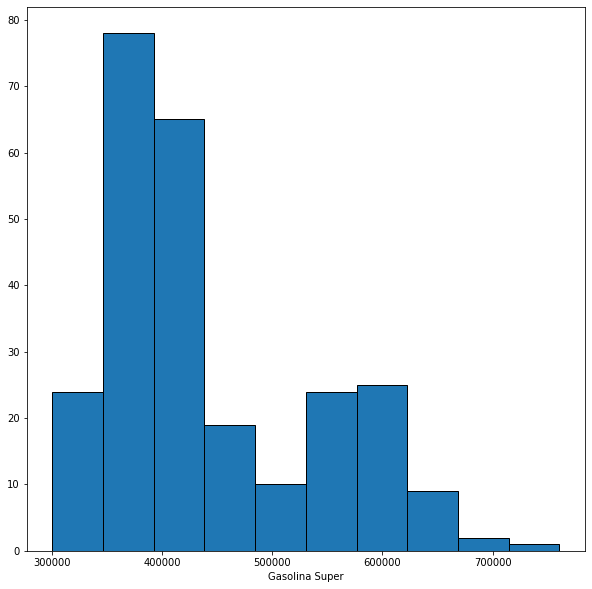

In [38]:
plt.hist(data_consumo['GasolinaSuper'], ec='black')
plt.xlabel('Gasolina Super')
plt.show()

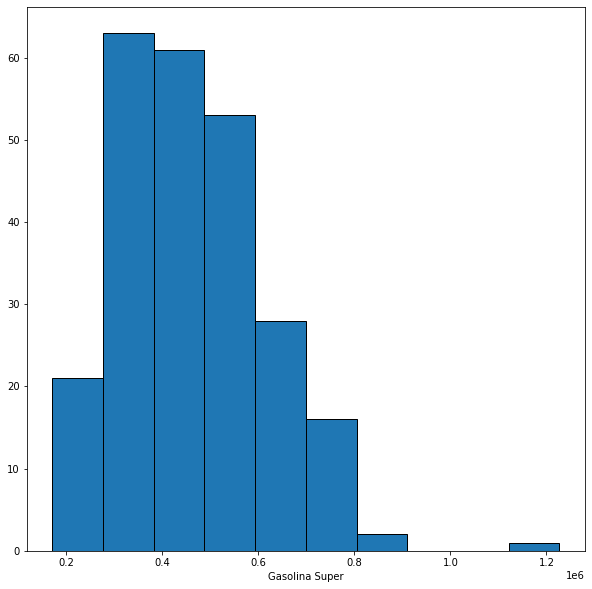

In [39]:
plt.hist(data_importaciones['GasolinaSuper'], ec='black')
plt.xlabel('Gasolina Super')
plt.show()

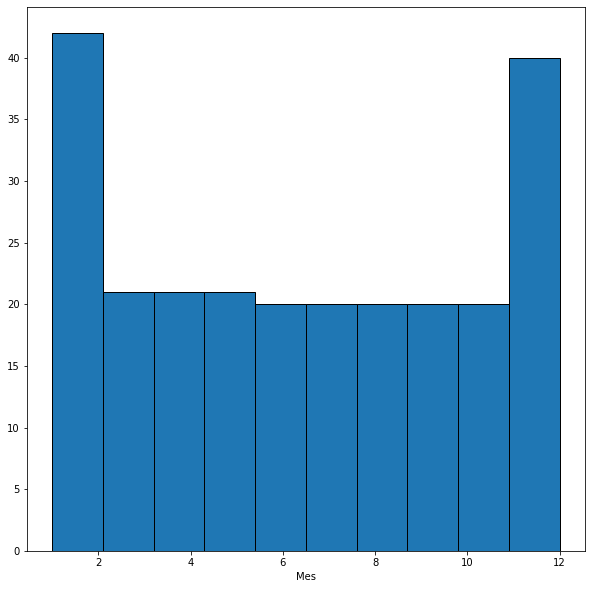

In [41]:
plt.hist(data_importaciones['Mes'], ec='black')
plt.xlabel('Mes')
plt.show()

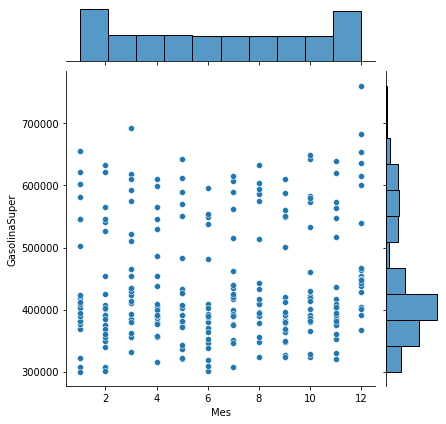

In [46]:
_ = sns.jointplot(x='Mes', y='GasolinaSuper', data=data_consumo)

In [6]:
anio = data_consumo.Anio*10000
mes = data_consumo.Mes*100+1
data_consumo['Date'] = pd.to_datetime((data_consumo.Anio*10000+data_consumo.Mes*100+1).apply(str),format='%Y%m%d')

anio = data_importaciones.Anio*10000
mes = data_importaciones.Mes*100+1
data_importaciones['Date'] = pd.to_datetime((data_importaciones.Anio*10000+data_importaciones.Mes*100+1).apply(str),format='%Y%m%d')

In [7]:
data_consumo.index = data_consumo.Date
data_importaciones.index = data_importaciones.Date

# Serie univariante

### Super consumo

In [8]:
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=1000):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data_consumo, x=data_consumo.Date, y=data_consumo.GasolinaSuper, title='Gasolina Super')

Inicio: 2000 ; Fin: 2021 ; Frecuencia: cada 12 meses/1 año

### Super importaciones

In [9]:
plot_df(data_importaciones, x=data_importaciones.Date, y=data_importaciones.GasolinaSuper, title='Gasolina Super')

Inicio: 2000 ; Fin: 2021 ; Frecuencia: cada 12 meses/1 año

# Descomposición de la serie en componentes

### Super dataset consumo

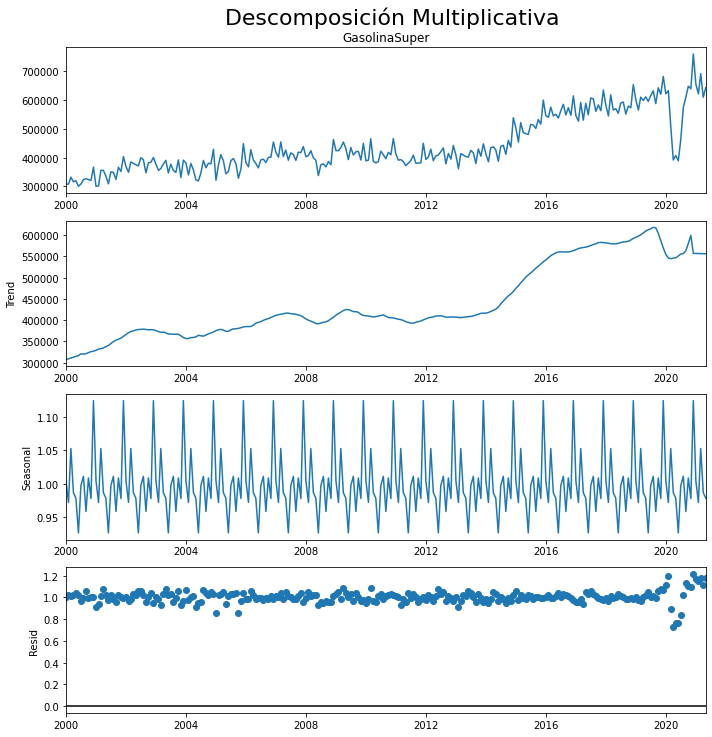

In [10]:
result_mul = seasonal_decompose(data_consumo['GasolinaSuper'], model='multiplicative', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
_ = result_mul.plot().suptitle('Descomposición Multiplicativa', fontsize=22, x=0.55, y=1.02)

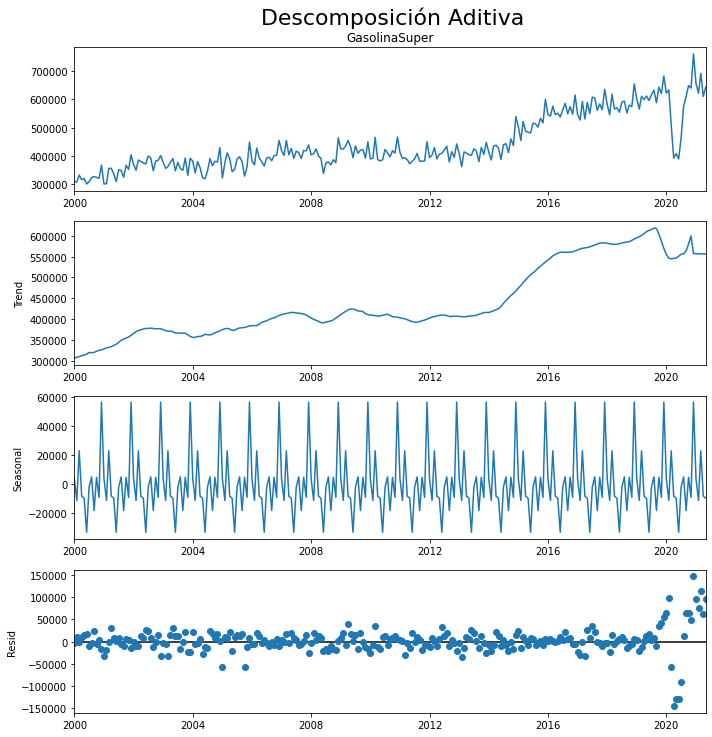

In [11]:
result_add = seasonal_decompose(data_consumo['GasolinaSuper'], model='additive', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
_ = result_add.plot().suptitle('Descomposición Aditiva', fontsize=22, x=0.55, y=1.02)

### Super dataset importaciones

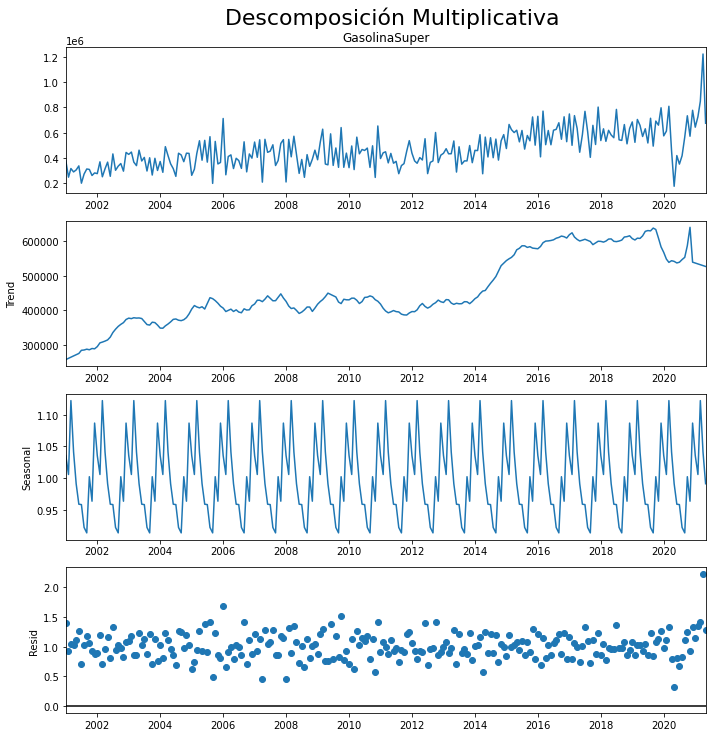

In [12]:
result_mul = seasonal_decompose(data_importaciones['GasolinaSuper'], model='multiplicative', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
_ = result_mul.plot().suptitle('Descomposición Multiplicativa', fontsize=22, x=0.55, y=1.02)

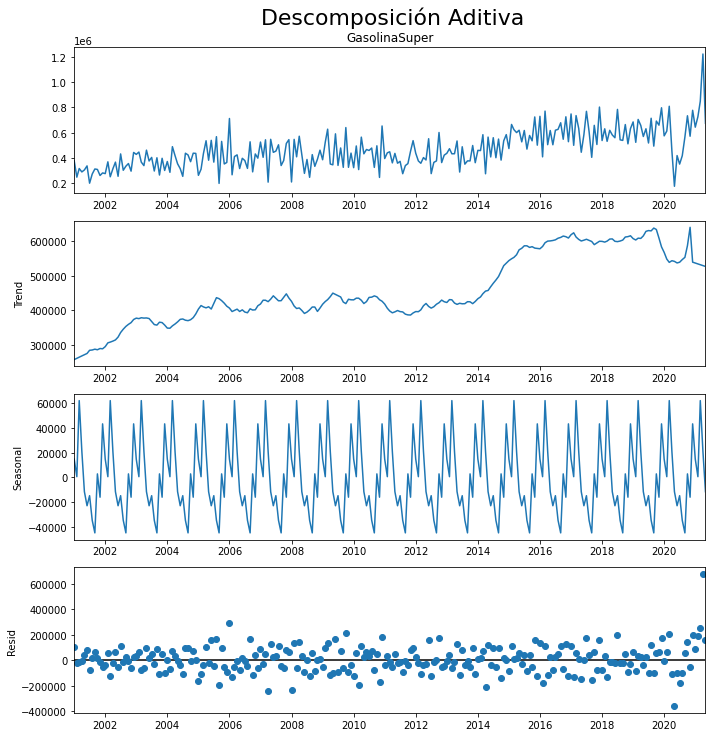

In [29]:
result_add = seasonal_decompose(data_importaciones['GasolinaSuper'], model='additive', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
_ = result_add.plot().suptitle('Descomposición Aditiva', fontsize=22, x=0.55, y=1.02)

Se puede observar que en ambos dataset es estacionaria en varianza pero no en media ya que si es observable cierta tendencial

# Graficos Autocorrelación

### Super consumo

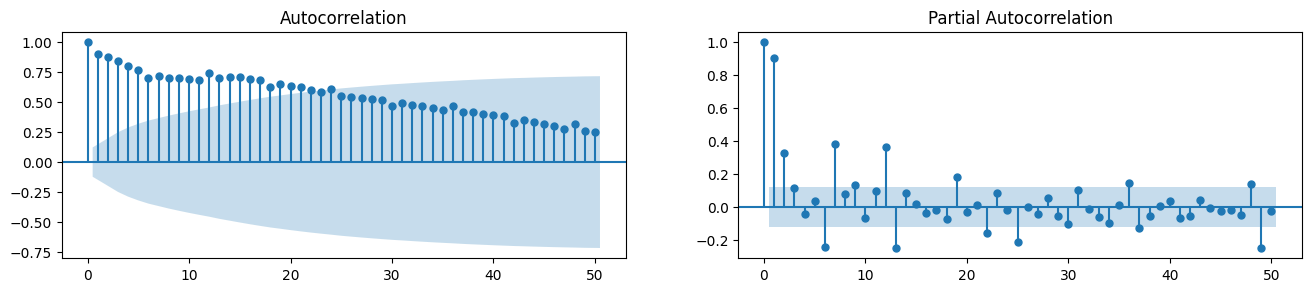

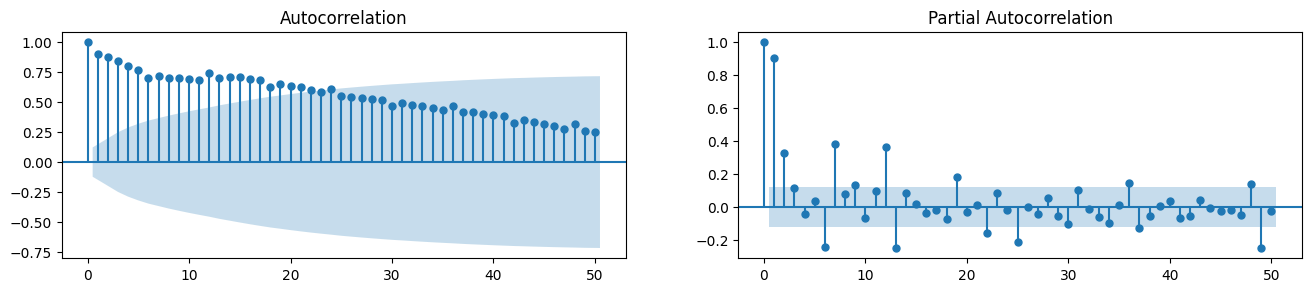

In [14]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data_consumo.GasolinaSuper.tolist(), lags=50, ax=axes[0])
plot_pacf(data_consumo.GasolinaSuper.tolist(), lags=50, ax=axes[1])

### Super importaciones

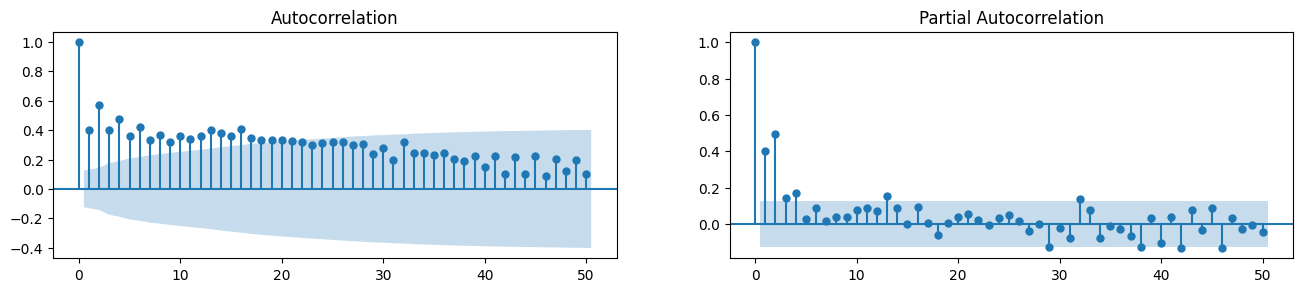

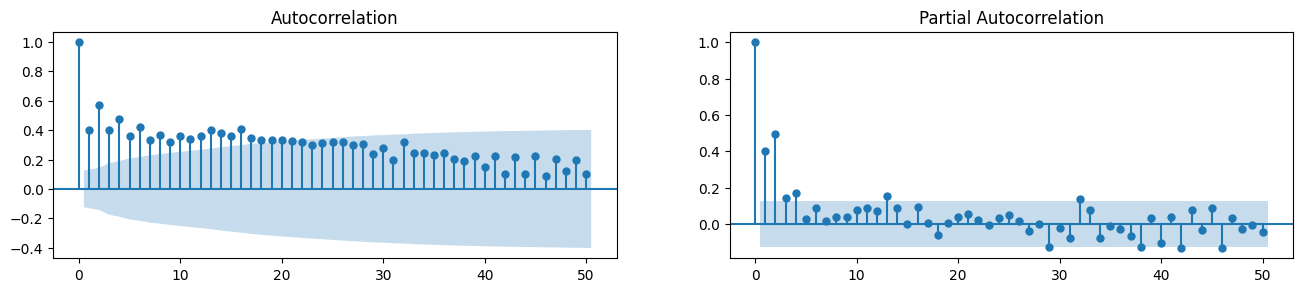

In [30]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data_importaciones.GasolinaSuper.tolist(), lags=50, ax=axes[0])
plot_pacf(data_importaciones.GasolinaSuper.tolist(), lags=50, ax=axes[1])

Se puede observar que los valores estan autocorrelacionados, de manera que los valores anteriores del sesgo pueden ser utiles para predecir el valor actual.

# Prueba de Dickey-Fuller

### Super consumo

In [16]:
result = adfuller(data_consumo.GasolinaSuper, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.18613387013775287
p-value: 0.940154366626028
Critial Values:
   1%, -3.4575505077947746
Critial Values:
   5%, -2.8735087323013526
Critial Values:
   10%, -2.573148434859185


### Super importaciones

In [31]:
result = adfuller(data_importaciones.GasolinaSuper, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.7417617731245076
p-value: 0.40973407063597966
Critial Values:
   1%, -3.4577787098622674
Critial Values:
   5%, -2.873608704758507
Critial Values:
   10%, -2.573201765981991


En ambos casos se puede notar que hay un p-value mayor a 0.05, de manera que se rechaza la hipotesis nula.

# Modelo ARIMA

### Super consumo

                               SARIMAX Results                                
Dep. Variable:          GasolinaSuper   No. Observations:                  257
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3054.674
Date:                Fri, 06 Aug 2021   AIC                           6117.348
Time:                        18:20:11   BIC                           6131.529
Sample:                    01-01-2000   HQIC                          6123.051
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7821      0.109     -7.172      0.000      -0.996      -0.568
ma.L1          0.4441      0.105      4.237      0.000       0.239       0.649
ma.L2         -0.3758      0.040     -9.372      0.0

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  war

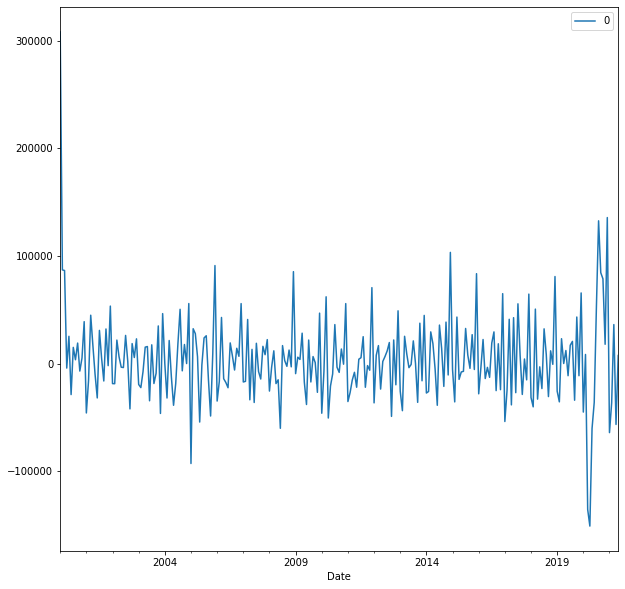

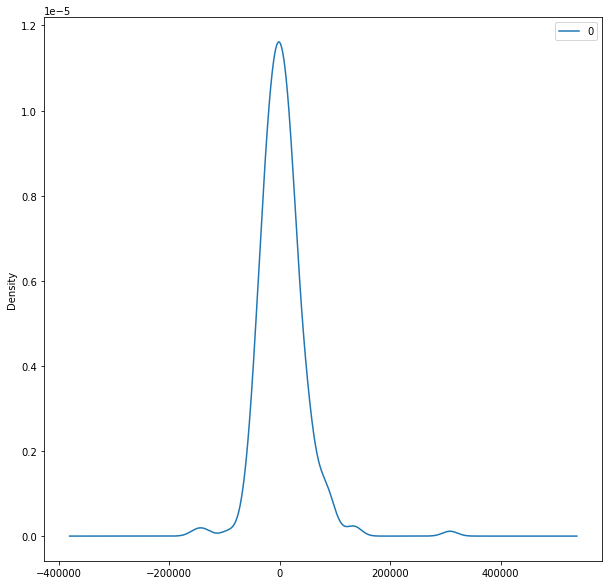

                   0
count     257.000000
mean     4040.826744
std     41315.726901
min   -151062.468396
25%    -18756.973157
50%       -23.803268
75%     21817.804979
max    308156.820000


In [18]:
model = ARIMA(data_consumo['GasolinaSuper'], order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

### Super importaciones

                               SARIMAX Results                                
Dep. Variable:          GasolinaSuper   No. Observations:                  245
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3180.800
Date:                Fri, 06 Aug 2021   AIC                           6369.601
Time:                        18:20:11   BIC                           6383.589
Sample:                    01-01-2001   HQIC                          6375.235
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7489      0.127     -5.882      0.000      -0.998      -0.499
ma.L1         -0.2366      0.132     -1.795      0.073      -0.495       0.022
ma.L2         -0.4144      0.127     -3.265      0.0

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


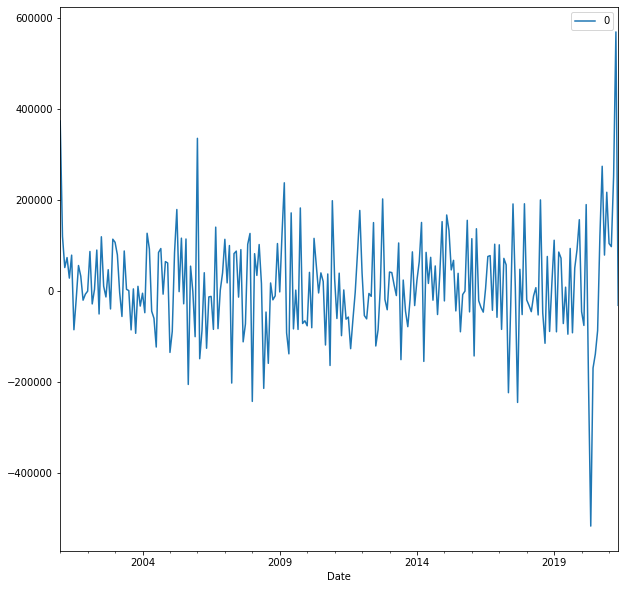

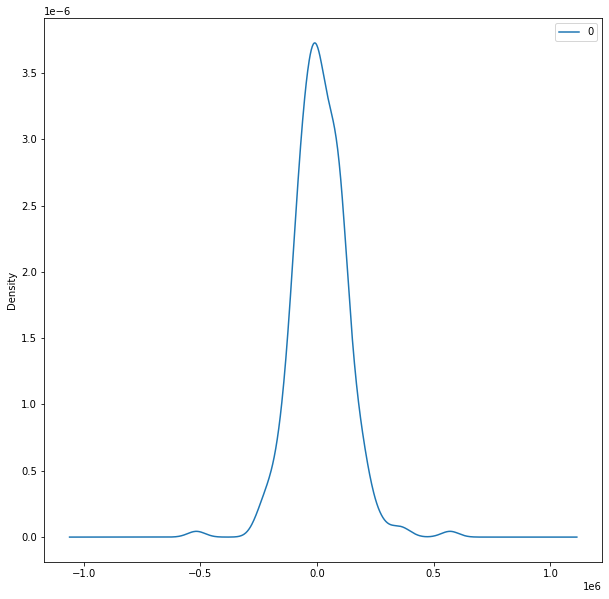

                   0
count     245.000000
mean    13262.591170
std    112670.687286
min   -517065.250384
25%    -54018.761751
50%      3862.480855
75%     84798.702647
max    569916.061112


In [19]:
model = ARIMA(data_importaciones['GasolinaSuper'], order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

# Prophet

### Super consumo

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.86444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       642.027    0.00129843        134.01   1.715e-05       0.001      131  LS failed, Hessian reset 
      99       642.268   0.000432978        58.122      0.3161           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       642.743     0.0001211       50.9799   1.519e-06       0.001      288  LS failed, Hessian reset 
     191       642.815   0.000359711       59.3747   7.346e-06       0.001      354  LS failed, Hessian reset 
     199       642.836   0.000151672       60.5973      0.9562      0.9562      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       643.229    0.00213353       224.969   1.729e-05       0.001      504  LS failed, Hessian reset 
     299       643.401   4.09108e-05       58.9369           1   

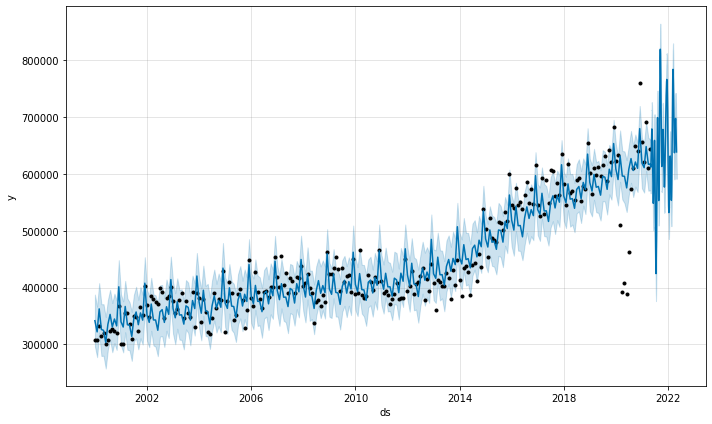

In [20]:
data_consumo["ds"] = data_consumo.Date
data_consumo["y"] = data_consumo.GasolinaSuper

data = data_consumo[["ds","y"]]

m = Prophet()
m.fit(data_consumo)

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

### Super importaciones

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.37208
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       471.478    0.00219037       101.092           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       471.901   1.19528e-06       87.1524      0.5166      0.5166      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       471.902   1.03415e-05       83.0106   1.199e-07       0.001      294  LS failed, Hessian reset 
     234       471.903   4.11361e-08       85.7451           1           1      329   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


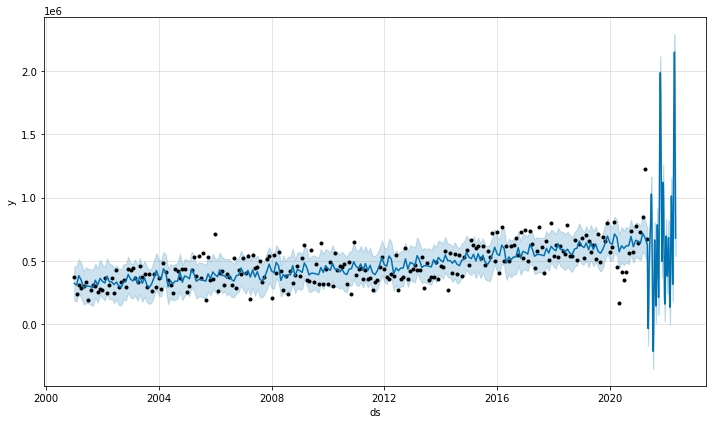

In [21]:
data_importaciones["ds"] = data_importaciones.Date
data_importaciones["y"] = data_importaciones.GasolinaSuper

data = data_importaciones[["ds","y"]]

m = Prophet()
m.fit(data_importaciones)

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

# Predicciones

### Ultimos 3 años, Super consumo

In [22]:
sarima_model = SARIMAX(data_consumo.GasolinaSuper, order=(2,0,1), seasonal_order=(2, 1, 0, 24))
results = sarima_model.fit()
results.aic

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10235D+01    |proj g|=  5.36683D-01

At iterate    5    f=  1.07028D+01    |proj g|=  2.18023D-02

At iterate   10    f=  1.07002D+01    |proj g|=  1.11317D-02

At iterate   15    f=  1.06934D+01    |proj g|=  8.21368D-03

At iterate   20    f=  1.06929D+01    |proj g|=  1.75170D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     24      1     0     0   1.710D-06   1.069D+01
  F =   10.692865315322887     

CONVERG

5508.132772075964

In [23]:
pred = results.get_prediction(start=pd.to_datetime('01/01/2000'), dynamic=False)
pred_ci = pred.conf_int()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


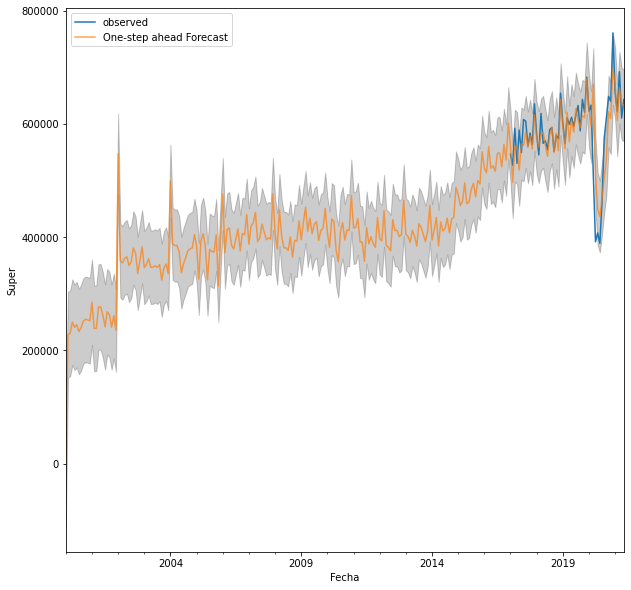

In [24]:
ax = data_consumo.GasolinaSuper['01/01/2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
 pred_ci.iloc[:, 0],
 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('Super')
plt.legend()

plt.show()

### Ultimos 3 años, Super importaciones

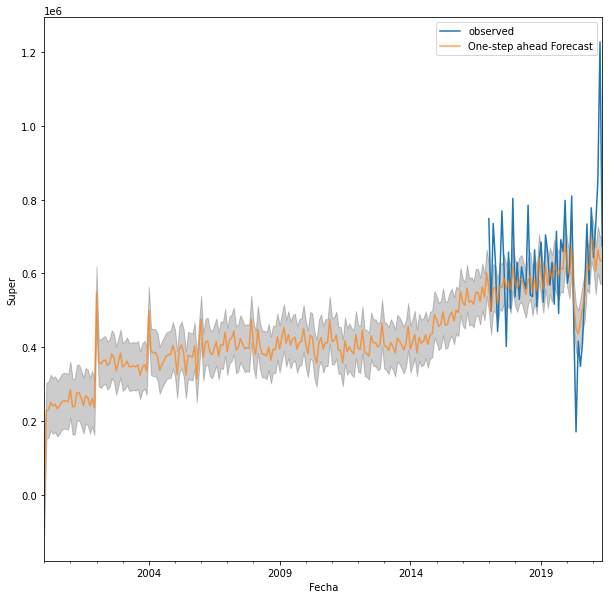

In [25]:
ax = data_importaciones.GasolinaSuper['01/01/2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
 pred_ci.iloc[:, 0],
 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('Super')
plt.legend()

plt.show()

### Año 2021, super consumo

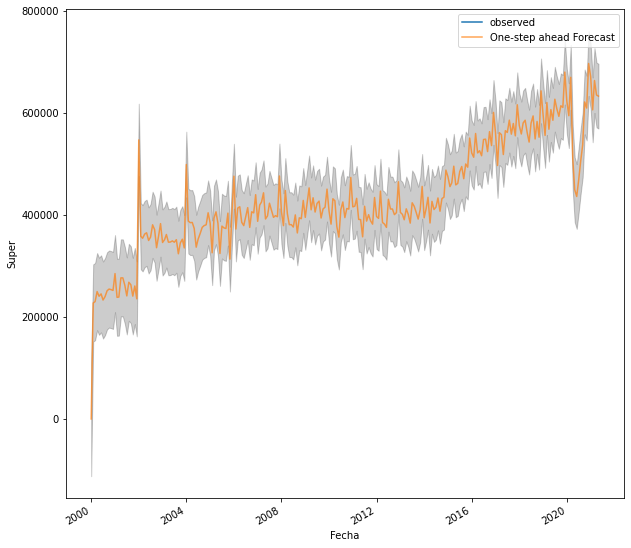

In [26]:
ax = data_consumo.GasolinaSuper['31/12/2021':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
 pred_ci.iloc[:, 0],
 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('Super')
plt.legend()

plt.show()

### Año 2021, super importaciones

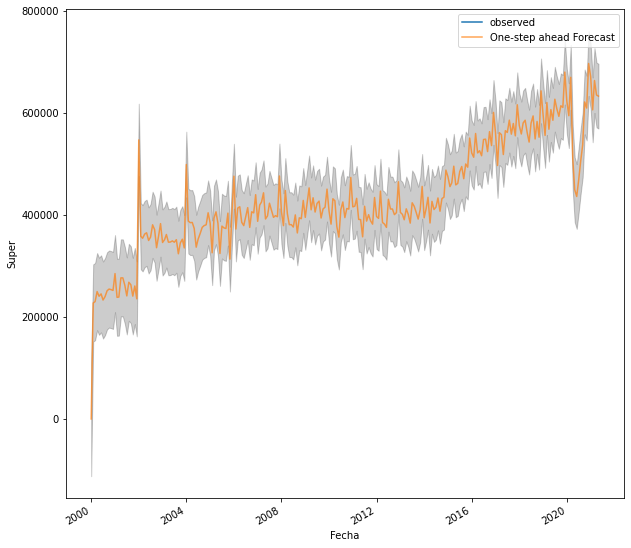

In [27]:
ax = data_importaciones.GasolinaSuper['31/12/2021':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
 pred_ci.iloc[:, 0],
 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('Super')
plt.legend()

plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


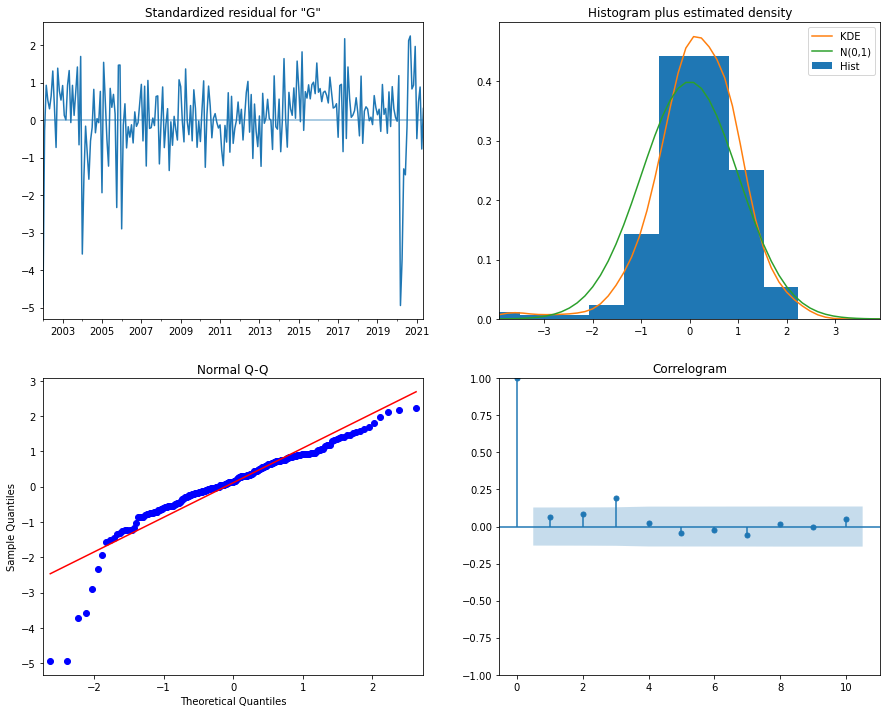

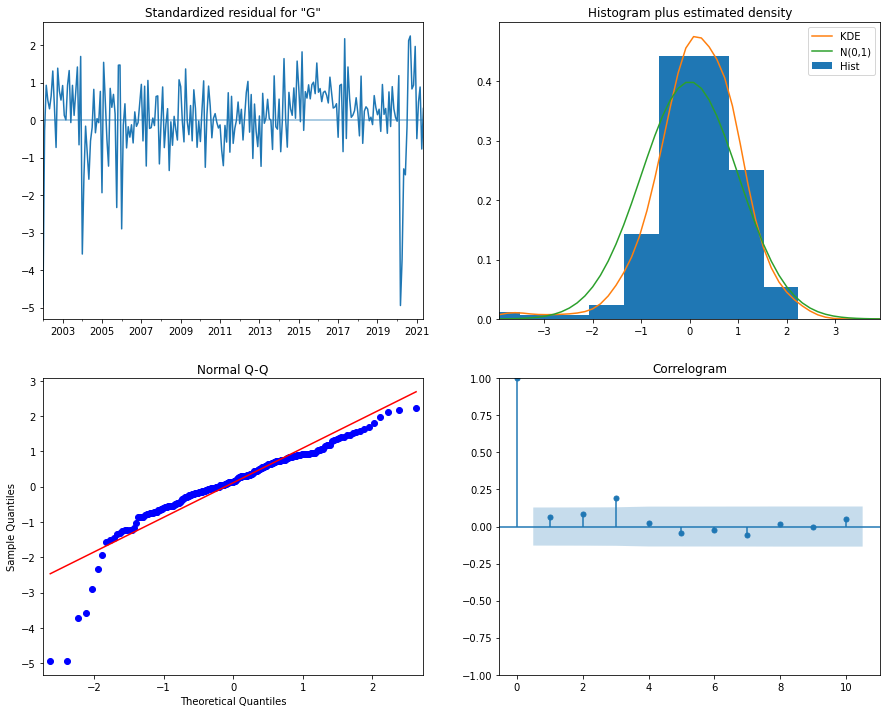

In [28]:
results.plot_diagnostics(figsize=(15, 12))

¿Qué tanto afectó las predicciones?¿se recuperaron los valores habituales en el regreso a la “nueva
normalidad” hasta el mayo de 2021?

En todas las graficas de la serie de tiempo se puede notar un pico, una crisis en el 2021. Los valores si regresaron a lo habitual, igual en lo que se predijo.